# Imports and Functions

In [43]:
import os
import pandas as pd
import numpy as np
import math
import cmath


import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from pmdarima import auto_arima

In [ ]:
##IMPORTANT: use this on the native dataframe (likely in another notebook). 
def clean_holidays(df):
    df["date"] = pd.to_datetime(df["date"]).dt.date

    df["description"] = df["description"].str.replace(r'\+\d+$', '', regex=True) #removes +n from specific holidays
    df["description"] = df["description"].str.replace(r'\-\d+$', '', regex=True) #removes -n from specific holidays

    new_holidays_col_names = {
        "description":"holiday_description",
        "type":"holiday_type"
    }
    df.rename(columns=new_holidays_col_names, inplace=True)

    return df


def clean_oil(df):
    df["date"] = pd.to_datetime(df["date"]).dt.date
    
    df = df.interpolate(method="linear")

    df.rename(columns={"dcoilwtico":"dol_per_barrel"}, inplace=True)
    
    return df

def clean_stores(df):
    new_stores_col_names = {
        "type":"store_type",
        "cluster":"store_cluster",
        "transactions":"store_transactions_per_day"
    }
    df.rename(columns=new_stores_col_names, inplace=True)

    return df

# Data

In [78]:
transx = pd.read_csv("../data/transactions.csv")
stores = pd.read_csv("../data/stores.csv")
oil = pd.read_csv("../data/oil.csv")
holidays = pd.read_csv("../data/holidays_events.csv")

training = pd.read_csv("../data/train.csv")
testing = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")

In [79]:
## Datetime conversion function

dated_dfs = [transx, oil, holidays, training, testing] #oil, holidays,
testing["date"] = pd.to_datetime(testing["date"]) #this is to show how we'll tag our testing df with all the pre-processing we need {A function will be the result of housing all the cleaning}


for df in dated_dfs:
    df["date"] = pd.to_datetime(df["date"]).dt.date
    print(type(df["date"][0]))

<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


# Cleaning

In [80]:
holidays = clean_holidays(holidays)
oil = clean_oil(oil)
stores = clean_stores(stores)

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_73883/716651310.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


In [81]:
display(holidays.head())
display(oil.head())
display(stores.head())

,date,holiday_type,locale,locale_name,holiday_description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,dol_per_barrel
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,store_nbr,city,state,store_type,store_cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [98]:
model_training = pd.merge(training, stores, on="store_nbr", how="inner")
model_training = model_training.set_index("id")
model_training = pd.merge(model_training, transx, on=["date", "store_nbr"], how="inner")
model_training = pd.merge(model_training, oil, on="date", how="left")
model_training = pd.merge(model_training, holidays, on="date", how="left")
model_training


,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,transactions,dol_per_barrel,holiday_type,locale,locale_name,holiday_description,transferred
0,2013-01-01,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805226,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2805227,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2805228,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2805229,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [100]:
model_testing = pd.merge(testing, stores, on="store_nbr", how="inner")
model_testing = model_testing.set_index("id")
# model_testing = pd.merge(model_testing, transx, on=["date", "store_nbr"], how="inner")
model_testing = pd.merge(model_testing, oil, on="date", how="left")
model_testing = pd.merge(model_testing, holidays, on="date", how="left")
model_testing

,date,store_nbr,family,onpromotion,city,state,store_type,store_cluster,dol_per_barrel,holiday_type,locale,locale_name,holiday_description,transferred
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN
28508,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN
28509,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN


In [102]:
model_testing.shape

(28512, 14)

Exactly how am I going to use SARIMAX to predict this shit? 

# Post Merge Cleaning

## Null Observation (Oil)

In [104]:
model_training.isnull().sum()

date                         0
store_nbr                    0
family                       0
sales                        0
onpromotion                  0
city                         0
state                        0
store_type                   0
store_cluster                0
transactions                 0
dol_per_barrel          807279
holiday_type           2346168
locale                 2346168
locale_name            2346168
holiday_description    2346168
transferred            2346168
dtype: int64

In [105]:
model_testing.isnull().sum()

date                       0
store_nbr                  0
family                     0
onpromotion                0
city                       0
state                      0
store_type                 0
store_cluster              0
dol_per_barrel          7128
holiday_type           26730
locale                 26730
locale_name            26730
holiday_description    26730
transferred            26730
dtype: int64

In [124]:
print(oil["date"].nunique())
print(model_training["date"].nunique())

print(model_training["date"].nunique() - oil["date"].nunique())

1218
1682
464


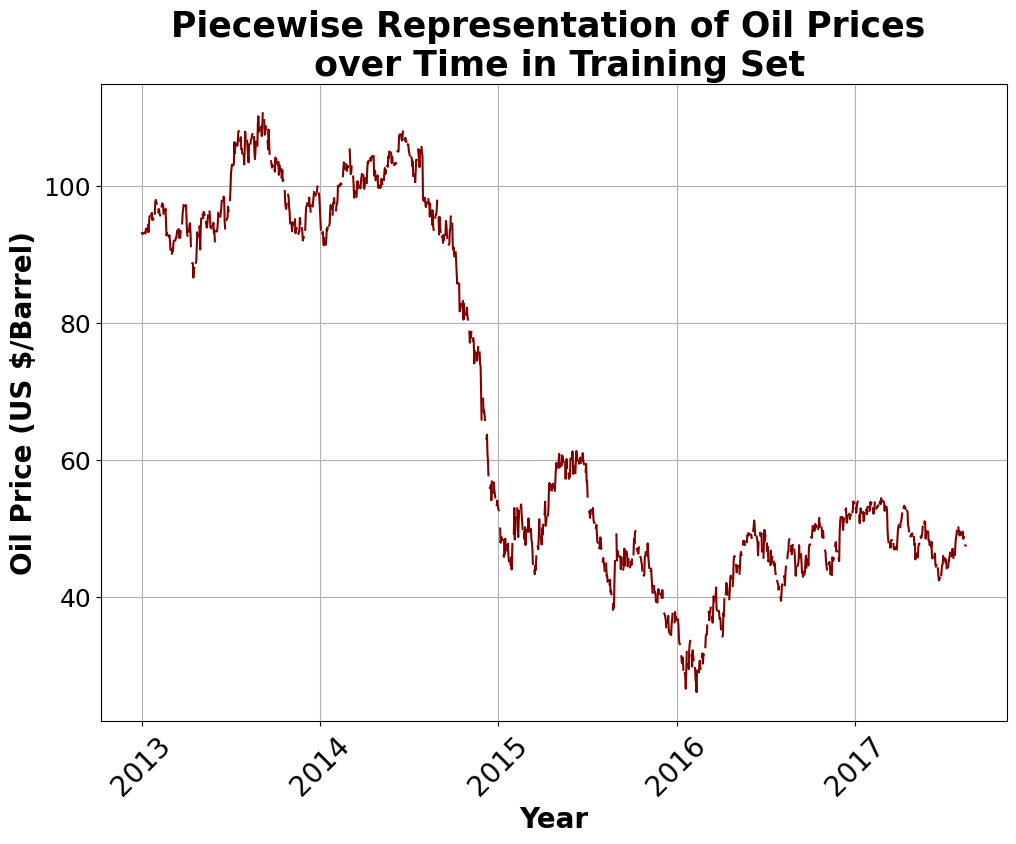

In [130]:
model_training_date_range = model_training["date"].to_list()

oil_sub_dfs = []

plot_training_oil = model_training.copy()

plot_filter = ["date", "dol_per_barrel"]
plot_training_oil = plot_training_oil[plot_filter]

plot_training_oil["group"] = (plot_training_oil["dol_per_barrel"].notnull() != plot_training_oil["dol_per_barrel"].notnull().shift()).cumsum() * plot_training_oil["dol_per_barrel"].notnull()

groups = plot_training_oil[ plot_training_oil["dol_per_barrel"].notnull() ].groupby("group")

plot_training_oil = plot_training_oil[ plot_training_oil["group"] != 0 ]

n_groups = groups.ngroups

# fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
plt.figure( figsize=(11.69,8.27) )

# for (group_id, group_data), ax in zip(groups, axes):
for group_id, group_data in groups:
    plt.plot(group_data["date"], group_data["dol_per_barrel"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

plt.title("Piecewise Representation of Oil Prices \n over Time in Training Set", size=25, fontweight="bold")
plt.xlabel("Year", size=20, fontweight="bold")
plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

plt.xticks(size="20", rotation=45)
plt.yticks(size="18")
plt.grid(axis="both")

plt.savefig("../images/training_oil_piecewise_over_time.png", format="png", dpi=300)

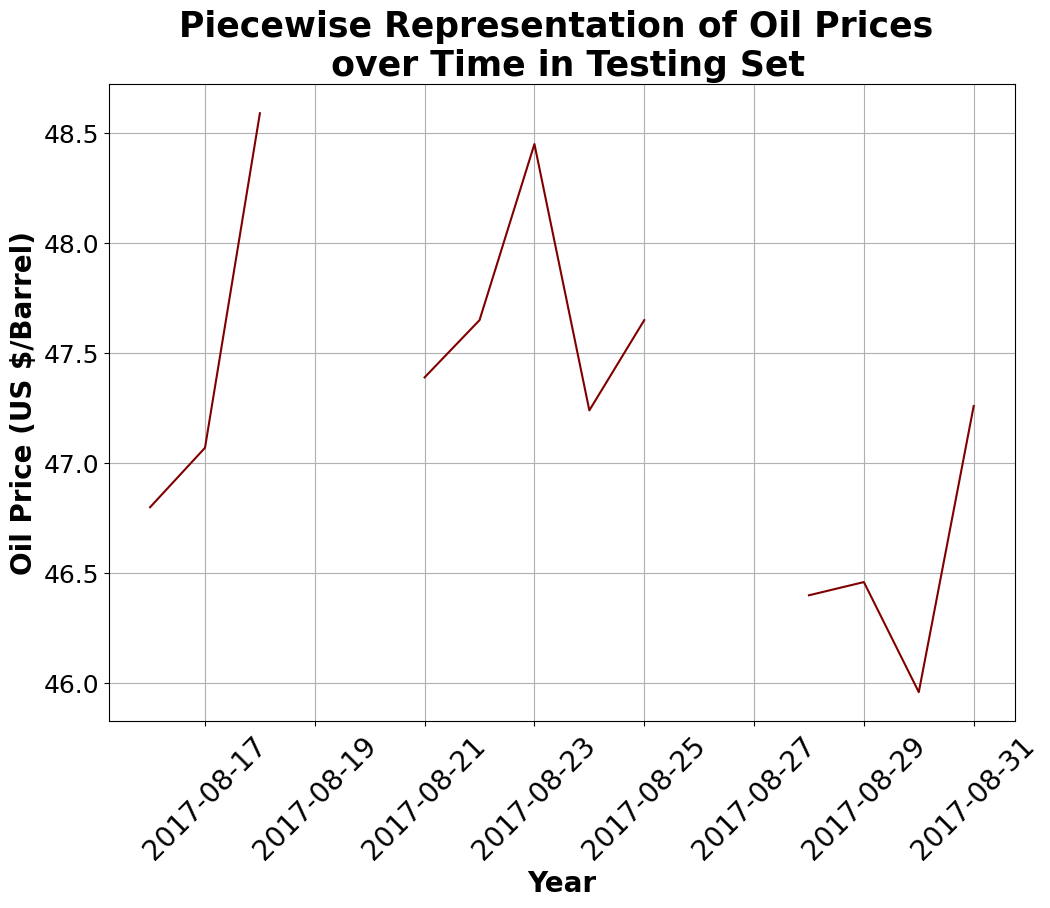

In [131]:
model_testing_date_range = model_testing["date"].to_list()

oil_sub_dfs = []

plot_testing_oil = model_testing.copy()

plot_filter = ["date", "dol_per_barrel"]
plot_testing_oil = plot_testing_oil[plot_filter]

plot_testing_oil["group"] = (plot_testing_oil["dol_per_barrel"].notnull() != plot_testing_oil["dol_per_barrel"].notnull().shift()).cumsum() * plot_testing_oil["dol_per_barrel"].notnull()

groups = plot_testing_oil[ plot_testing_oil["dol_per_barrel"].notnull() ].groupby("group")

plot_testing_oil = plot_testing_oil[ plot_testing_oil["group"] != 0 ]

n_groups = groups.ngroups

# fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
plt.figure( figsize=(11.69,8.27) )

# for (group_id, group_data), ax in zip(groups, axes):
for group_id, group_data in groups:
    plt.plot(group_data["date"], group_data["dol_per_barrel"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

plt.title("Piecewise Representation of Oil Prices \n over Time in Testing Set", size=25, fontweight="bold")
plt.xlabel("Year", size=20, fontweight="bold")
plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

plt.xticks(size="20", rotation=45)
plt.yticks(size="18")
plt.grid(axis="both")

plt.savefig("../images/testing_oil_piecewise_over_time.png", format="png", dpi=300)

## Lagged Transactional Features

In [144]:
test_training = model_training.copy()

deduplicated = test_training.groupby(["date", "store_nbr"], as_index=False)["transactions"].first() #2023-01-01 actually only appears once here for one store...probably have to omit

deduplicated["rolling_30day_avg_traffic"] = deduplicated.groupby("store_nbr")["transactions"].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
deduplicated["rolling_16day_avg_traffic"] = deduplicated.groupby("store_nbr")["transactions"].transform(lambda x: x.rolling(window=16, min_periods=1).mean())

deduplicated
# test_model_training["prev_16day_traffic"] = model_training["transactions"].shift(16)

,date,store_nbr,transactions,rolling_30day_avg_traffic,rolling_16day_avg_traffic
0,2013-01-01,25,770,770.000000,770.0000
1,2013-01-02,1,2111,2111.000000,2111.0000
2,2013-01-02,2,2358,2358.000000,2358.0000
3,2013-01-02,3,3487,3487.000000,3487.0000
4,2013-01-02,4,1922,1922.000000,1922.0000
...,...,...,...,...,...
83483,2017-08-15,50,2804,2727.100000,2761.1875
83484,2017-08-15,51,1573,1667.633333,1677.5000
83485,2017-08-15,52,2255,2321.666667,2376.5000
83486,2017-08-15,53,932,1097.333333,1103.0000


In [147]:
merge_test = model_training.copy()

merge_test = merge_test.merge(deduplicated[ ["date", "store_nbr", "rolling_30day_avg_traffic", "rolling_16day_avg_traffic"] ], on=["date", "store_nbr"], how="left")

merge_test

,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,transactions,dol_per_barrel,holiday_type,locale,locale_name,holiday_description,transferred,rolling_30day_avg_traffic,rolling_16day_avg_traffic
0,2013-01-01,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0000
1,2013-01-01,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0000
2,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0000
3,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0000
4,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805226,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.3125
2805227,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.3125
2805228,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.3125
2805229,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1964.6,2040.3125


Next ques:

- how do I insert images into LaTeX? What does the capital [H] mean when I am placing an image somewhere? 

- if I can't get the lagged feature above to work, I will note it in my paper and then state that attempts were made to make it work, but the attempts did not prove successful. It will be noted for a future expansion on the project and therefore, transactions will not be considered. 

# Encoding

In [ ]:
non_encodable_columns = [
    "onpromotion", #this probably is good as is
    "dol_per_barrel" #this is probably fine
]

encodable_columns = [
    "store_number", #because it is already numerical, there may be some implied hierarchy...we don't want that
    "family", #onehot appropriate
    "city", #onehot
    "state", #onehot
    "store_type", #onehot...perhaps there is use in having some hierarchy...would need to double check what distinguishes types
    "store_cluster", #not sure on this
    "holiday_type", #will substitute NaN with "no holiday type"
    "locale", #will substitute NaN with "no holiday locale"
    "locale_name", #will substitute with "no holiday locale name"
    "holiday_description", #will substitute with "no holiday description"
    "transferred", #will substitute with no holiday transfer
]

# Feature Creation

- sales by transactions to get an average sale per transaction

In [ ]:
#training and test

training_y = df.iloc[:-]